In [1]:
import pandas as pd # Importação da Biblioteca pandas
# Carregamento do dataset utilizad
df_peso = pd.read_stata(r'C:\Users\vimed\Downloads\banco_ISA_Vinicius (1).dta')
df = pd.read_csv(r'C:\Users\vimed\Downloads\Data_Set_para_Contrafactuais.csv')
# Junção dos datase  pelo chave-primaria id
df = df.merge(df_peso,right_on='id_original', left_on='id', how='inner')
#limpar o nomes das colunas
df = df.loc[:, ~df.columns.str.endswith(('_x', '_y'))]


# Análise Regressiva

In [2]:
import pandas as pd
import statsmodels.api as sm

# fazer uma copia do dataframe inicial
df = df.copy()
# seleção das colunas utilizadas
cols_num = ['AFTOTAL2', 'AFTOTAL1', 'km2015', 'km2020']
# conversao para números, em caso de não conversao(NAT), remoção de linhas  nao certas
for c in cols_num:
    df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna(subset=cols_num)

# calcula  as diferenças entre 2020 e 2015
df['Delta_minutos'] = df['AFTOTAL2'] - df['AFTOTAL1']
df['Delta_km'] = df['km2020'] - df['km2015']
# filtragem apenas da observações reais que tiveram impato
df_valido = df[df['Delta_km'] != 0]
 # Modelo de regressão  das diferenças
y_diff = df_valido['Delta_minutos']
# Aplicação da regressão  via biblioteca Stats models do panda
X_diff = sm.add_constant(df_valido[['Delta_km']])
modelo_diff = sm.OLS(y_diff, X_diff).fit()

print("\nRegressão de diferenças (2020-2015) ")
print(modelo_diff.summary())

# Coeficientes da regressão
beta0 = modelo_diff.params['const']  # Intercepto
beta1 = modelo_diff.params['Delta_km']  # Coeficiente angular

# Numero de Anos no Intervalo
num_anos =6
# Calculo do Aumento Anual
aumento_medio_anual = beta1 / num_anos  
print(f"Efeito médio anual: {aumento_medio_anual:.2f} minutos por semana por ano por km de ciclovia")





Regressão de diferenças (2020-2015) 
                            OLS Regression Results                            
Dep. Variable:          Delta_minutos   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.755
Date:                Tue, 02 Dec 2025   Prob (F-statistic):              0.187
Time:                        09:23:08   Log-Likelihood:                -2279.8
No. Observations:                 251   AIC:                             4564.
Df Residuals:                     249   BIC:                             4571.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2

In [ ]:

#Conversão das Datas de Nascimentos Incorretas ,caso contrário,filtragem/remoção
def remover_datas_invalidas(df, coluna="datanasc"):
    # em caso de não conversão substituicao por nat
    df[coluna] = pd.to_datetime(df[coluna], dayfirst=True, errors='coerce')
    # retirada as linhas  com não conversao via padronizada
    df = df.dropna(subset=[coluna]).reset_index(drop=True)
    return df
# aplicação da função 
df = remover_datas_invalidas(df)
df['datanasc']


=== DISTRIBUIÇÃO Simulação Contafactual I(Retirada das Ciclovias) ===
                     2015_base  2015  2016  2017  2018  2019  2020
Sedentário                  55    60    78    95   114   129   156
Pouco Ativo                 69    96    94    92    91    97    86
Moderadamente Ativo         90    86    91    89    96    86    82
Ativo                       96    82    69    72    58    57    55
Extremamente Ativo         457   443   435   419   408   398   388

Porcentagem:
                     2015_base   2015   2016   2017   2018   2019   2020
Sedentário                7.17   7.82  10.17  12.39  14.86  16.82  20.34
Pouco Ativo               9.00  12.52  12.26  11.99  11.86  12.65  11.21
Moderadamente Ativo      11.73  11.21  11.86  11.60  12.52  11.21  10.69
Ativo                    12.52  10.69   9.00   9.39   7.56   7.43   7.17
Extremamente Ativo       59.58  57.76  56.71  54.63  53.19  51.89  50.59


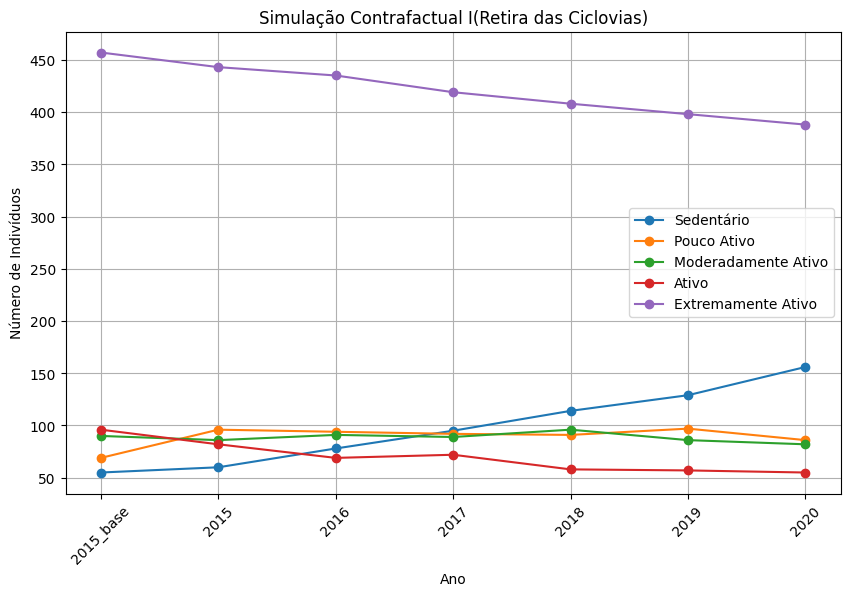

In [4]:
import pandas as pd # importacao de biblioteca manipulação de dados
import matplotlib.pyplot as plt # biblitoeca gráfica

#período de ano analisados( 2015(base) +2015-2020-contrafactual)
anos = range(2015, 2021)
#fator de   progressivo de retirada de minutos globais de atividade fisica por ano
impacto_progressivo_por_km_ano = 30.76
# categorização dos individuos pelo nível de atividade fisica por meio de técnica de lista em Estrutura de Dados
categorias = ["Sedentário", "Pouco Ativo", "Moderadamente Ativo", "Ativo", "Extremamente Ativo"]
# Uso de Metodo de mapeamento para classificação do fator de atividade fisica  de acordo com a classificação  em Nivel de Atividade fisica
mapa_fatores = {
    "Sedentário": 1.2,
    "Pouco Ativo": 1.35,
    "Moderadamente Ativo": 1.55,
    "Ativo": 1.72,
    "Extremamente Ativo": 1.9
}
#função para aplicação da categorização  dos individuos por minuto de atividade fisica
def classificar_atividade(minutos):
    try:
        val = float(minutos) # conversão para estrutura primaria de dados float, junto com tratamento de erro
    except:
        return "Sedentário"
    if val <= 0:
        return "Sedentário"
    elif val < 150:
        return "Pouco Ativo"
    elif val < 300:
        return "Moderadamente Ativo"
    elif val < 450:
        return "Ativo"
    else:
        return "Extremamente Ativo"
# função para aplicaçõa criação de de colunas de  Fatores de atividade fisica baseado no dicionario e classificacao de atividade fisica
def classificar_e_mapear(df, coluna_minutos, prefixo):
    df[prefixo] = df[coluna_minutos].apply(classificar_atividade)
    df[f'Fator_{prefixo}'] = df[prefixo].map(mapa_fatores)
    return df
#função para a criação dos do cenário contrafactual por  do calculo acumulado de retirada dos minutos ano a pos ano.
def f_contrafactual(df):
    coluna_2015 = 'AFTOTAL1' # Coluna base de Minutos de base 2015
    #criação de outra colunas associado ao periodo do inicio do contrafactual
    df['Minutos_CF_2015_base'] = df[coluna_2015]
    classificar_e_mapear(df, 'Minutos_CF_2015_base', 'Classificacao_Atividade_CF_2015_base')
 # Interação via Looping para os anos contrafactuais
    for ano in range(2015, 2021):
        efeito = impacto_progressivo_por_km_ano * (ano - 2015 + 1)
        col_minutos = f'Minutos_CF_{ano}' # criação de um coluna temporaria
        #subtração do efeito ou do ano  em relacao ao ano, limitando por meio de técnica de clipagem(ou seja,se a pessoa nao tem minutos, não pode passar de zero)
        df[col_minutos] = (df[coluna_2015] - efeito).clip(lower=0)
        #classificação e Interação ano a ano contrafactual de cada pessoa
        classificar_e_mapear(df, col_minutos, f'Classificacao_Atividade_CF_{ano}')
        
    return df
# quantitifação de individuos em cada categoria
def calcular_distribuicoes_cf_sub_com_base(df):
    #contagem via ano base de 2015
    contagem = pd.DataFrame(index=categorias)
    contagem['2015_base'] = df['Classificacao_Atividade_CF_2015_base'].value_counts().reindex(categorias).fillna(0).astype(int)
    #interacao via loop (contagem) para cada ano contrafactual  associado
    for ano in anos:
        contagem[ano] = df[f'Classificacao_Atividade_CF_{ano}'].value_counts().reindex(categorias).fillna(0).astype(int)
        # aplicação de calculo porcentual  para cada categoria
    porcentagem = (contagem.div(contagem.sum(axis=0), axis=1) * 100).round(2)
    return contagem, porcentagem
# função expressão grafica das categorias
def plot_distribuicoes(contagem_cf_sub):
    plt.figure(figsize=(10, 6))
    for categoria in categorias:
        valores = [contagem_cf_sub.loc[categoria, '2015_base']] + [contagem_cf_sub.loc[categoria, ano] for ano in anos]
        anos_plot = ['2015_base'] + list(anos)
        plt.plot(range(len(anos_plot)), valores, marker='o', label=categoria)
    plt.title('Simulação Contrafactual I(Retira das Ciclovias)')
    plt.xlabel('Ano')
    plt.ylabel('Número de Indivíduos')
    plt.xticks(range(len(anos_plot)), anos_plot, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

df_base = df.copy()
df_base = f_contrafactual(df_base)
contagem_cf_sub, porcentagem_cf_sub = calcular_distribuicoes_cf_sub_com_base(df_base)

print("\n=== DISTRIBUIÇÃO Simulação Contafactual I(Retirada das Ciclovias) ===")
print(contagem_cf_sub)
print("\nPorcentagem:")
print(porcentagem_cf_sub)

plot_distribuicoes(contagem_cf_sub)

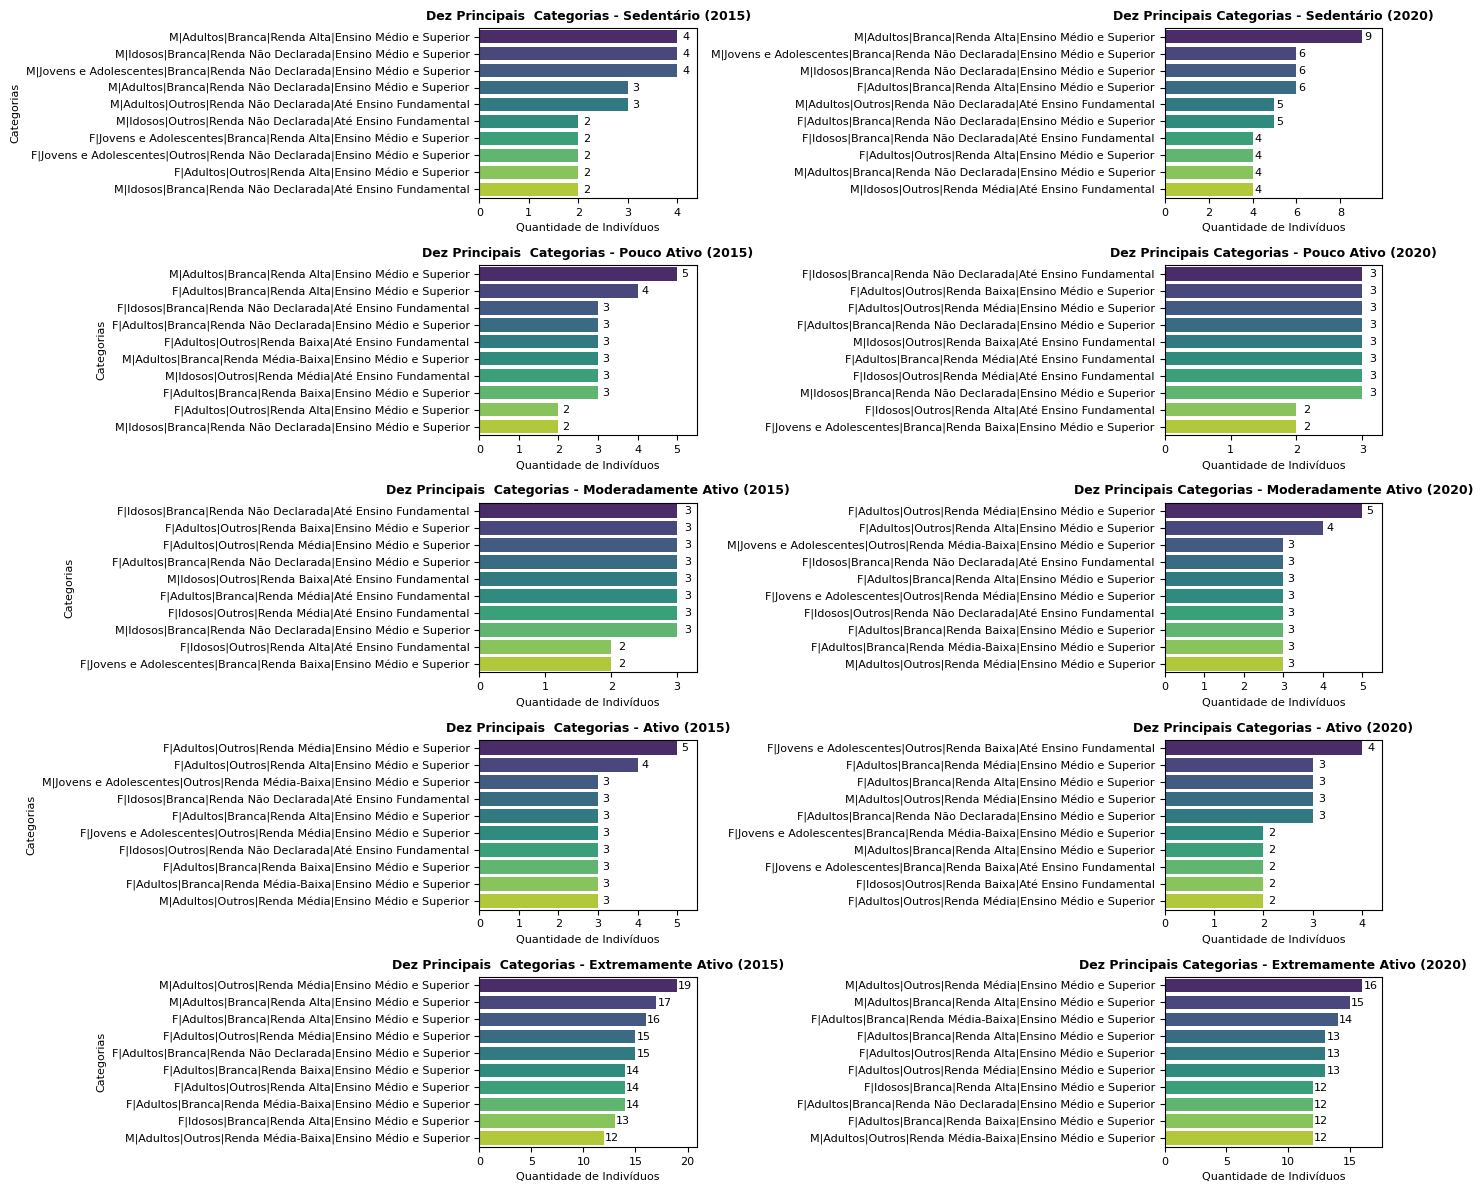

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_resultado = df_base.copy()
# colunas referencias para cada ano para verificar cada as classes 
def plot_top10_categorias_por_atividade_2015_2020(df):
    col_atividade_2015 = 'Classificacao_Atividade_CF_2015'
    col_atividade_2020 = 'Classificacao_Atividade_CF_2020'
    col_categoria = 'Categorias'
# metodo de listagem para verificar por cada categoria quais são as classes mais frequentes
    categorias_atividade = [
        "Sedentário", "Pouco Ativo", "Moderadamente Ativo",
        "Ativo", "Extremamente Ativo"
    ]
# uso do grid e do suplots para a  figura via 5 categorias e duas colunas
    fig, axs = plt.subplots(5, 2, figsize=(14, 12))
    axs = axs.flatten() # indexação linear

    for i, atividade in enumerate(categorias_atividade):
        #filtragem dos individuos via categoria para o bloco do ano de2015
        df_2015 = df[df[col_atividade_2015] == atividade]
        cont_2015 = (
            df_2015[col_categoria]
            .value_counts()
            .head(10)  # os topo 10
            .reset_index()
        ) # quantificação 
        cont_2015.columns = ['Categorias', 'Quantidade']
        # plotagem gráfica
        sns.barplot(
            data=cont_2015,
            y='Categorias',
            x='Quantidade',
            hue='Categorias',
            legend=False,
            palette='viridis',
            ax=axs[i * 2]
        )


        for j, v in enumerate(cont_2015['Quantidade']):
            axs[i * 2].text(
                v + 0.1, j, f"{v}",
                color='black', va='center', fontsize=8
            )

        axs[i * 2].set_title(
            f'Dez Principais  Categorias - {atividade} (2015)',
            fontsize=9, fontweight='bold'
        )
        axs[i * 2].set_xlabel('Quantidade de Indivíduos', fontsize=8)
        axs[i * 2].set_ylabel('Categorias', fontsize=8)
        axs[i * 2].tick_params(axis='both', which='major', labelsize=8)
        axs[i * 2].set_xlim(0, max(1, cont_2015['Quantidade'].max() * 1.1))

           #filtragem dos individuos via categoria para o bloco do ano de 2020
        df_2020 = df[df[col_atividade_2020] == atividade]
        cont_2020 = (
            df_2020[col_categoria]
            .value_counts()# contagem
            .head(10) #contagem dos individuos mais frequentes
            .reset_index()
        )
        cont_2020.columns = ['Categorias', 'Quantidade']
# plot do gráfico
        sns.barplot(
            data=cont_2020,
            y='Categorias',
            x='Quantidade',
            hue='Categorias',
            legend=False,
            palette='viridis',
            ax=axs[i * 2 + 1]
        )

        for j, v in enumerate(cont_2020['Quantidade']):
            axs[i * 2 + 1].text(
                v + 0.1, j, f"{v}",
                color='black', va='center', fontsize=8
            )

        axs[i * 2 + 1].set_title(
            f'Dez Principais Categorias - {atividade} (2020)',
            fontsize=9, fontweight='bold'
        )
        axs[i * 2 + 1].set_xlabel('Quantidade de Indivíduos', fontsize=8)
        axs[i * 2 + 1].set_ylabel('')
        axs[i * 2 + 1].tick_params(axis='both', which='major', labelsize=8)
        axs[i * 2 + 1].set_xlim(0, max(1, cont_2020['Quantidade'].max() * 1.1))

    plt.tight_layout(pad=1.0)
    plt.show()


# execucao 
plot_top10_categorias_por_atividade_2015_2020(df_resultado)


In [16]:
novas_colunas = []
colunas_vistas = set()
# Limpeza (remodelacao dos nomes)
for col in df.columns:
    col_base = col.replace('_x', '').replace('_y', '')
    if col_base in colunas_vistas:
        # 
        contador = 1
        while f"{col_base}_{contador}" in colunas_vistas:
            contador += 1
        col_base = f"{col_base}_{contador}"
    
    colunas_vistas.add(col_base)
    novas_colunas.append(col_base)

df.columns = novas_colunas



# Limpeza  de colunas com nomes errado
df = df[[col for col in df.columns if not col.endswith('_dup')]]
# atribuição do dataframe de processamento
df_original = df_base.copy()

# Simulação

In [ ]:
#Foi necessario criar outro dataframe para Calorias para Não dar problema
# dataframe auxiliar carregado somente com os valores caloricos associados
df_calorias = pd.read_excel(
    r'C:\Users\vimed\Downloads\Dados_Mestrado_07_05_2025 (1).NeW_Teste_@_Ajustado_Ajuste.xlsx',
    sheet_name='Tabela Auxiliar_Consumo Caloric',
    engine='openpyxl' 
) 
#remoção de colunas desnecenssaárias
df_calorias.drop(columns=[
    'Coluna1',
    'Coluna2',
    'Unnamed: 4',
    'Unnamed: 5',
    'Unnamed: 6',
    'Unnamed: 7',
    'Chavemento pof',
    'Kcal-dia.1'
], inplace=True)

df_calorias

,Chavemento pof e ISA,Kcal-dia
0,M|Adultos|Outros|Renda Alta|Ensino Médio e Sup...,1306.500
1,M|Jovens e Adolescentes|Outros|Renda Média-Bai...,829.630
2,M|Adultos|Outros|Renda Média-Baixa|Até Ensino ...,1455.890
3,F|Adultos|Outros|Renda Alta|Ensino Médio e Sup...,2636.490
4,M|Adultos|Branca|Renda Média|Ensino Médio e Su...,1420.615
...,...,...
2357,M|Adultos|Outros|Renda Não Declarada|Até Ensin...,1161.565
2358,M|Adultos|Branca|Renda Não Declarada|Ensino Mé...,2029.671
2359,M|Adultos|Branca|Renda Não Declarada|Até Ensin...,2046.021
2360,F|Idosos|Outros|Renda Média|Até Ensino Fundame...,816.652


In [ ]:
# Bibliotecas Necessárias para a Simulação
import torch
import numpy as np
import pandas as pd
import random
import warnings

# Necessária a Incorporação de uma Fixador-Aleatorio para Garantir Reprodutibilidade do Modelo Probabilistico
SEED = 42
random.seed(SEED)   # Fixador para controle dos numeros aleatorios gerados do Python
np.random.seed(SEED)  # Fixador para controle dos numeros aleatorios gerados da Biblioteca Numpy
torch.manual_seed(SEED)  # Fixador para controle dos numeros aleatorios gerados da Biblioteca do Pythorch
# sincronização.
if torch.cuda.is_available(): # Verificação se há disponivel uma CPU CUDA Compatível, se houver, ele garante que todos os processos paralelizados possuam o mesmo fixador em paralelo.
    torch.cuda.manual_seed_all(SEED)

## Conversão e Padronização de Datas na Simulação com Tratamento de ERRO, com callback
def converter_data_brasil_ou_americano(data):
    if pd.isna(data):
        return pd.NaT
    #preserva as datas já convertidas
    if isinstance(data, (pd.Timestamp, pd.DatetimeTZDtype)):
        return data
    # realização vai mais uma verificação  de conversão de data com trtamento de erro via padrão brasileiro e americano
    if isinstance(data, str):
        data = data.strip()
        if data == '':
            return pd.NaT
        #tratamento  via tentativa DD/MM/AAAA
    try:
        return pd.to_datetime(data, format='%d/%m/%Y', errors='raise')
    except Exception:
        try: # com tratamento de erro YYYY/MM/DD
            return pd.to_datetime(data, format='%Y-%m-%d', errors='raise')
        except Exception:
            warnings.warn(f"Erro a padronizar/converter: {data}. Retornando NaT.")
        return pd.NaT

#####################################################################################################
#Execução das Simulações Via Pytorch

# Função da Simulação Geral
def simulacao_torch(df_original, df_calorias, num_semanas, num_simulacoes):

    df = df_original.copy().reset_index(drop=True)
    
    # Aplicar conversão de data(funcao supracitada)
    df['datanasc'] = df['datanasc'].apply(converter_data_brasil_ou_americano)
       
    # Conferência das colunas importantes para a simulação
    colunas_obrigatorias = ['peso', 'datanasc', 'sexo', 'altura', 'id', 'Categorias']
    for coluna in colunas_obrigatorias:
        if coluna not in df.columns:
            raise ValueError(f"Coluna Ausente: {coluna}")
        
    # Anos da simulação com relação aos fatores de atividade fisica
    anos = list(range(2015, 2021))  # 2015 a 2020

    # Mapeamento de anos para colunas de fatores 
    mapeamento_colunas_fatores = {
        2015: 'Fator_Classificacao_Atividade_CF_2015',
        2016: 'Fator_Classificacao_Atividade_CF_2016', 
        2017: 'Fator_Classificacao_Atividade_CF_2017',
        2018: 'Fator_Classificacao_Atividade_CF_2018',
        2019: 'Fator_Classificacao_Atividade_CF_2019',
        2020: 'Fator_Classificacao_Atividade_CF_2020'
    }

    # Verificar quais colunas existem no dataframe
    colunas_existentes = df.columns
    mapeamento_fatores_categoria = {}
    # criação de um dicionario para cada categoria  e ano sob as simulações
    for categoria in df['Categorias'].unique():
        for ano in anos:
            coluna_fator = mapeamento_colunas_fatores.get(ano)
            
            if coluna_fator and coluna_fator in colunas_existentes:
                valores = df.loc[(df['Categorias'] == categoria) & (df[coluna_fator].notna()), coluna_fator].unique()
                # Criação de Tratamento de erro, caso não encontre, usar o valor padrão de  como sedentário.
                if len(valores) > 0:
                    mapeamento_fatores_categoria[(categoria, ano)] = valores.astype(np.float32)
                else:
                    mapeamento_fatores_categoria[(categoria, ano)] = np.array([1.2], dtype=np.float32)
                    print(f" Categoria '{categoria}', ano {ano} - uso do  valor  1.2")
            else:
                mapeamento_fatores_categoria[(categoria, ano)] = np.array([1.2], dtype=np.float32)
                print(f"Coluna '{coluna_fator}' não achada  ano {ano} - usado o valor  1.2")

    # Processamento das Datas de Aniversários, Idade e Peso, e Sexo
    dias_nascimento = df['datanasc'].dt.normalize().values.astype('datetime64[D]').astype('int64')
    num_individuos = len(df) 
    ids = df['id'].values
    peso_inicial = df['peso'].astype(float).values.astype(np.float32) 
    altura = df['altura'].astype(float).values.astype(np.float32)
    sexo = (df['sexo'].astype(str) == 'M').astype(np.float32).values
    
    # Mapeando as Categorias dos Individuos.
    categorias, indices_categorias = np.unique(df['Categorias'].values, return_inverse=True)
    indices_categorias = indices_categorias.astype(np.int64)
    num_categorias = len(categorias)

    # Uso do Dataframe das Calorias por Categorias por pelo metod 
    mapeamento_calorias_categoria = {}
    for categoria in categorias:
        valores = df_calorias.loc[df_calorias['Chavemento pof e ISA'] == categoria, 'Kcal-dia'].dropna().astype(float).values.astype(np.float32)
        mapeamento_calorias_categoria[categoria] = valores
        
    # Método do Map paras as categorias
    valores_concatenados = np.concatenate([mapeamento_calorias_categoria[c] for c in categorias])
    indices_categorias_map = {}
    comeco_idx = 0
    for c in categorias:
        fim_idx = comeco_idx + len(mapeamento_calorias_categoria[c])
        indices_categorias_map[c] = (comeco_idx, fim_idx)
        comeco_idx = fim_idx
    valores_concatenados_t = torch.tensor(valores_concatenados, dtype=torch.float32)

    # Converter para tensores
    tensor_peso_inicial = torch.tensor(peso_inicial)
    tensor_altura = torch.tensor(altura)
    tensor_sexo = torch.tensor(sexo)
    tensor_dias_nascimento = torch.tensor(dias_nascimento)
    tensor_indices_categorias = torch.tensor(indices_categorias, dtype=torch.long)
    
    # Input para Data Inicial da Simulação
    data_base = np.datetime64('2015-01-01').astype('datetime64[D]').astype('int64')
    
    # Armazenamento dos Resultados
    resultados = []
    # funcao para determinar o índice do ano com base na semana atual de simulacao
    def semana_para_ano_idx(semana):
        return min(semana // 52, len(anos)-1)
        
    for simulacao in range(num_simulacoes):
        peso_atual = tensor_peso_inicial.clone()
        #Inicializacao do tensor para o armazenamento do balanço energetico semanal
        balanco_semanas = torch.empty((num_individuos, num_semanas), dtype=torch.float32)
        # loop das semanas
        for semana in range(num_semanas):
            dias_passados = semana * 7
            dia_atual = data_base + dias_passados
            # calculo da idade do individuo, usando  a semana atual da simulação e a data de nascimento do individuo
            idade = ((dia_atual - tensor_dias_nascimento) // 365).to(torch.float32)

            ano_idx = semana_para_ano_idx(semana)
            ano = anos[ano_idx]
            # fator sorteado para cada individuo por semana
            fator_sorteado = torch.zeros(num_individuos)
            # Tensores
            for i, categoria in enumerate(categorias):
                indices_cat = (tensor_indices_categorias == i).nonzero(as_tuple=True)[0]
                if len(indices_cat) > 0:
                    fatores_disponiveis = mapeamento_fatores_categoria.get((categoria, ano), [1.2])
                    fatores_tensor = torch.tensor(fatores_disponiveis, dtype=torch.float32)
                    indices = torch.randint(0, len(fatores_tensor), (len(indices_cat),))
                    fator_sorteado[indices_cat] = fatores_tensor[indices]
            # Equação de Taxa Metabolica via St. Miffins por meio de vetor
            tmb_dia = (10.0 * peso_atual) + (6.25 * tensor_altura * 100.0) - (5.0 * idade) + (5.0 * tensor_sexo) + (-161.0 * (1.0 - tensor_sexo))
            gasto_semanal = tmb_dia * 7.0 * fator_sorteado
                        
            # Calorias por categoria
            idxs = []
            #sorteio calorico para 7 dias
            for idx in range(num_individuos):
                cat = categorias[tensor_indices_categorias[idx]]
                comeco, fim = indices_categorias_map[cat]
                rand_idx = torch.randint(comeco, fim, (7,))
                idxs.append(rand_idx.unsqueeze(0))
                
            idxs = torch.cat(idxs, dim=0)
            # aplicação dos limites de sorteio calorico entre 800 kcal até 5000 kcal por dia
            consumo_diario = torch.clamp(valores_concatenados_t[idxs], min=800.0, max=5000.0)
            consumo_semanal = consumo_diario.sum(dim=1)
            # Calculo do Balanço Energetico
            balanco_energetico = consumo_semanal - gasto_semanal
            # Estabelecimento do Limite inferior do peso com base no estado atual(na semana do individuo em porcentagem) e suavizacao
            limite_deficit = peso_atual * 0.008 * 7700.0 * (0.92 ** min(semana, 40))
            #Estabelecimento do Limite Superior do peso com base no estado atual(na semana do individuo em porcentagem) e suavizacao exponencial
            limite_superavit = peso_atual * 0.02 * 7700.0 * (0.92 ** min(semana, 40))
            # Clipagem via limites aceitaveis adotados
            balanco_energetico = torch.clamp(balanco_energetico, min=-limite_deficit, max=limite_superavit)
            balanco_semanas[:, semana] = balanco_energetico
            # Calculo do Peso do Individuo em determinanda semana.
            peso_atual = peso_atual + (balanco_energetico / 7700.0)
        # movimentar os dados dO Tensor flow para cpu(caso estejam na GPU) e converter para numpy
        balanco_cpu = balanco_semanas.detach().cpu().numpy()
        # criacao do dataframe  com cada coluna representando o balanço energetico por semana
        df_balanco = pd.DataFrame(balanco_cpu, columns=[f'semana_{i+1}' for i in range(num_semanas)])
        # adicionar cada id para identificar o individuo da simulacao
        df_balanco['id'] = ids
        # enumeracao  do numero da simulacao
        df_balanco['simulacao'] = simulacao + 1
        # armazenamento do dataframe  atual na lista de resutlados
        resultados.append(df_balanco)
        

    return resultados

# Chamada da Função com os Inputs de Semanas e Quantidades de Semanas Desejadas
resultados = simulacao_torch(df_original, df_calorias, num_semanas=314, num_simulacoes=100)


# Pós-Processamento

In [ ]:
#Concatenando os resultados por ano
df_simulacao = pd.concat(resultados, ignore_index=True)
# contagem das semanas por ano
semanas_por_ano = 52
# range de anos para percorer
anos = list(range(2015, 2021))

df_peso_inicial = df[['id', 'peso', 'altura']].drop_duplicates().copy()
# calcula o peso contrafactual acumulado por ano com base nas semanas da simulação
def calcular_peso_ano(df_sim, df_peso_inicial, anos, semanas_por_ano):
    pesos = {}
    for i, ano in enumerate(anos, start=1):
        semanas = i * semanas_por_ano
        colunas = [f'semana_{j+1}' for j in range(semanas)]
        acumulado = df_sim.groupby('id')[colunas].mean()
        pesos[ano] = df_peso_inicial.set_index('id')['peso'] + (acumulado.sum(axis=1) / 7700)
    return pesos
# Transformação dos pesos em relação ao contrafactaul
pesos_por_ano_contrafactual = calcular_peso_ano(df_simulacao, df_peso_inicial, anos, semanas_por_ano)

# Reindexação dos individuos, considerando o peso inicial na simulação,criando Dataframe final do  ID unico para peso e IMC
df_final = df[['id', 'Categorias', 'altura']].drop_duplicates().copy().set_index('id')
df_final['Peso_2015_base'] = df_peso_inicial.set_index('id')['peso']

# Loop do Calculo ano a ano do Peso contrafactaul
for ano in anos:
    df_final[f'Peso_{ano}_contrafactual'] = pesos_por_ano_contrafactual[ano].reindex(df_final.index)
df_final['IMC_2015_base'] = df_final['Peso_2015_base'] / (df_final['altura'] ** 2)
# Loop do Calculo ano a ano do IMC contrafactaul
for ano in anos:
    df_final[f'IMC_{ano}_contrafactual'] = df_final[f'Peso_{ano}_contrafactual'] / (df_final['altura'] ** 2)
df_final.reset_index(inplace=True)

# Função parar para mostrar as estatisticas descritivas dos individuos, considerando peso e IMC
def formatar_describe_planilha(df, tipo):
    dados = {}
    base = df[f'{tipo}_2015_base'].describe() # calculo das estatisticas de 2015 base
    dados['Estatística'] = base.index.tolist() + ['n_pessoas'] # adiciona o numero de pessoas
    dados[f'{tipo}_2015_base'] = base.values.tolist() + [df[f'{tipo}_2015_base'].count()]
    #loop de interacao anual para fazer isso 
    for ano in anos:
        d = df[f'{tipo}_{ano}_contrafactual'].describe()
        dados[f'{tipo}_{ano}_contrafactual'] = d.values.tolist() + [df[f'{tipo}_{ano}_contrafactual'].count()]
    return pd.DataFrame(dados).round(2)

# Exibir as estatisticas das Simulações
print("Estatistica ")
print("\n Peso da Simualação(2015-2020)") 
print(formatar_describe_planilha(df_final, 'Peso').to_string(index=False))
print("\nImc")
print(formatar_describe_planilha(df_final, 'IMC').to_string(index=False))

# Definição do Ultimo ano de Simulação 
ultimo_ano = anos[-1]
peso = df_final[f'Peso_{ultimo_ano}_contrafactual'].describe()
imc = df_final[f'IMC_{ultimo_ano}_contrafactual'].describe()

#Exibir estatistica do ultimo ano
print(f"\n-Finais {ultimo_ano} -")
print("\nPeso")
print(pd.DataFrame({'Estatística': peso.index.tolist()+['n_pessoas'], # Contagem de Individuos
                    'Valor': peso.values.tolist()+[df_final[f'Peso_{ultimo_ano}_contrafactual'].count()]}).round(2).to_string(index=False))
print("\nImc:")
print(pd.DataFrame({'Estatística': imc.index.tolist()+['n_pessoas'],
                    'Valor': imc.values.tolist()+[df_final[f'IMC_{ultimo_ano}_contrafactual'].count()]}).round(2).to_string(index=False))


Estatistica 

 Peso da Simualação(2015-2020)
Estatística  Peso_2015_base  Peso_2015_contrafactual  Peso_2016_contrafactual  Peso_2017_contrafactual  Peso_2018_contrafactual  Peso_2019_contrafactual  Peso_2020_contrafactual
      count          767.00                   767.00                   767.00                   767.00                   767.00                   767.00                   767.00
       mean           70.75                    67.03                    66.73                    66.48                    66.30                    66.15                    66.04
        std           15.75                    13.27                    12.91                    12.56                    12.21                    11.90                    11.61
        min           34.00                    35.50                    35.36                    35.24                    35.18                    35.14                    35.43
        25%           60.00                    57.64             

# Visualizacao sob o Acompanhamento do Peso e Estados Nutricionais

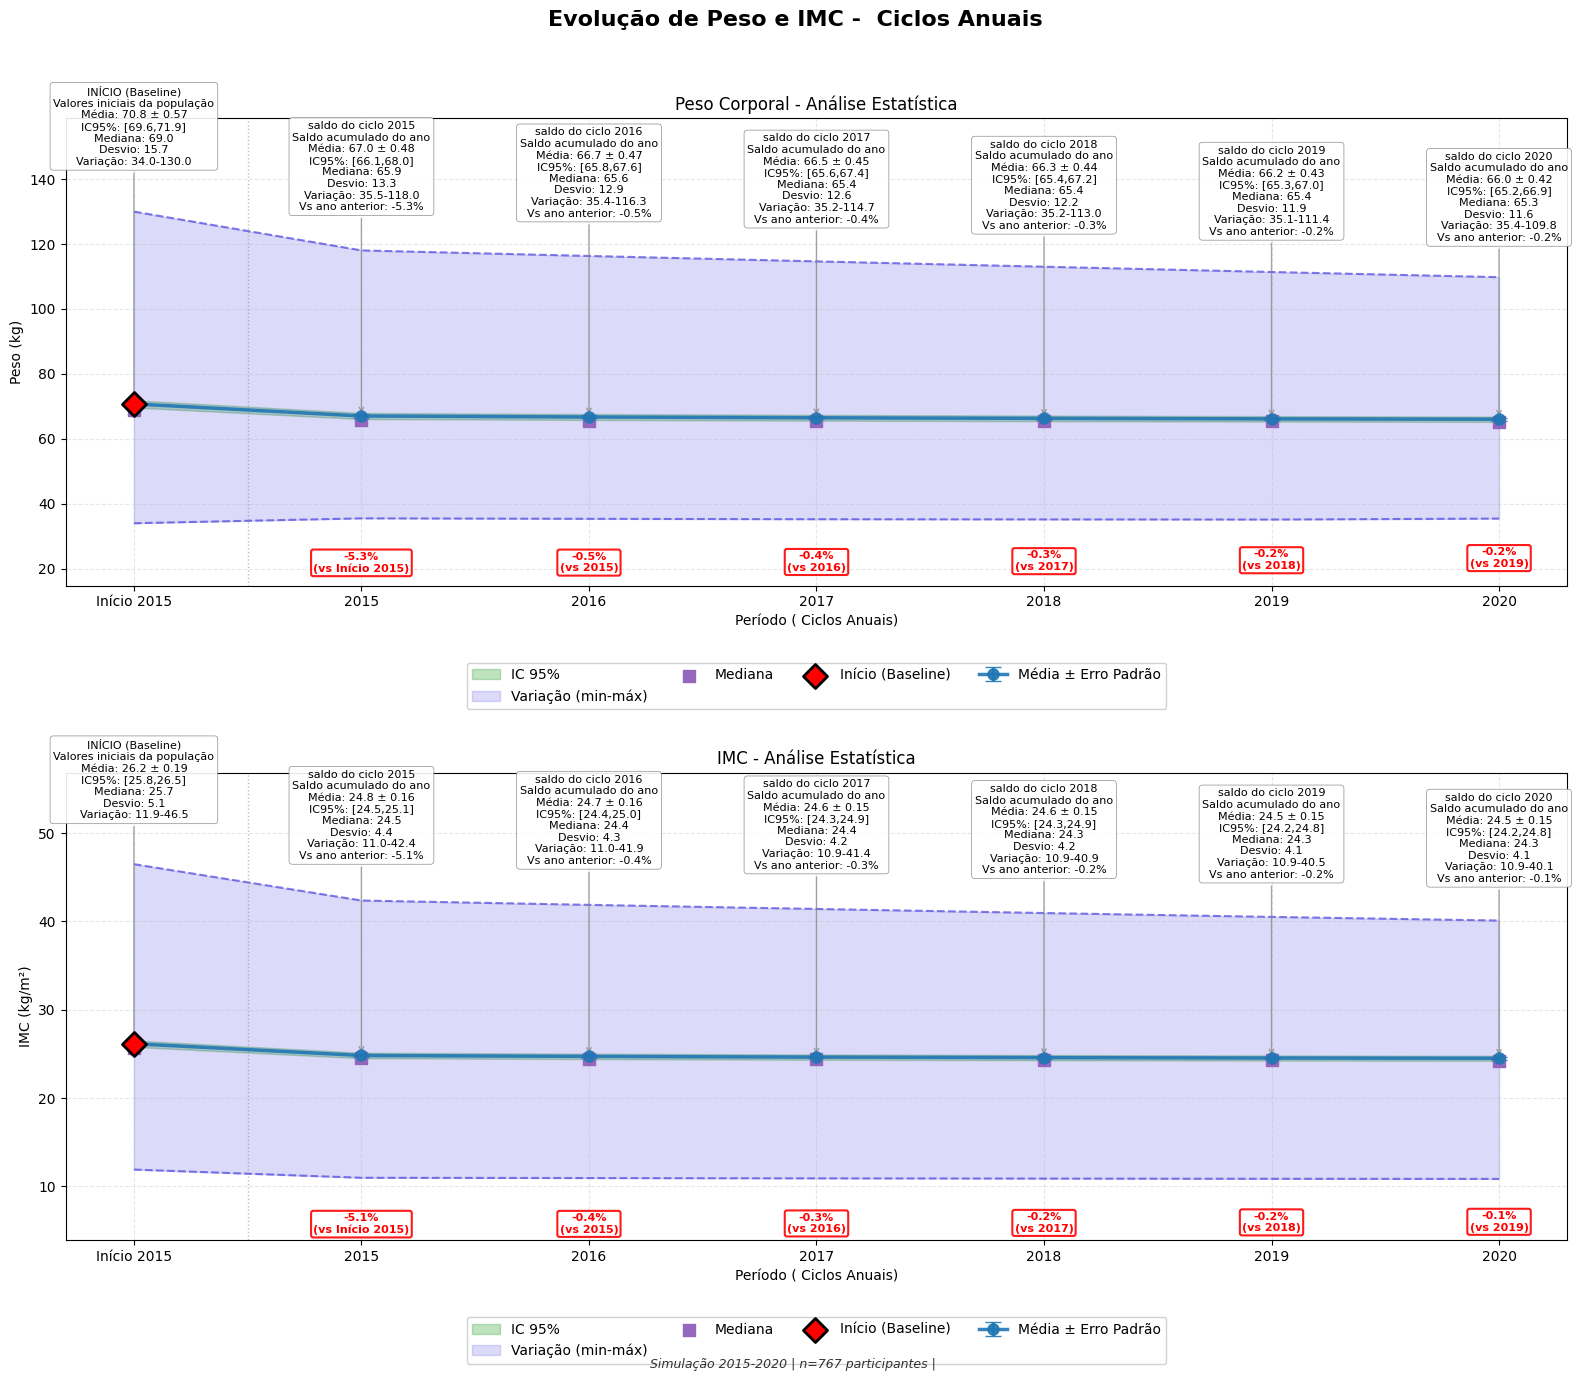

In [ ]:
# Bibliotecas usadas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

# calculo estatísticas descritivas e intervalos de confiança (IC95%)
def analisar_estatisticas_peso_imc(df_final):
    anos = [2015, 2016, 2017, 2018, 2019, 2020] # Anos analisados
    anos_com_base = ['Início 2015'] + anos # Anos de Inicio (Baseline)
    cores = ['#1f77b4', "#0ecfff", '#2ca02c', "#4e46de", '#9467bd']# Paleta de Cores
# estilo e ajuste de fontes
    plt.style.use('default')
    plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.size': 10})
# funcao  para retorno do tipo e ano  em relacao ao coluna do dataframe
    def nome_coluna(tipo, ano):
        return f'{tipo}_2015_base' if ano == 'Início 2015' else f'{tipo}_{ano}_contrafactual'
# funcao para calculo de  media, desvio, ic95%, variacao e amplitude para cada ano
    def calcular_estatisticas(tipo):
        resultados = {k: [] for k in ['medias','medianas','desvios','erros_medios','ic95','variacoes',
                                      'minimos','maximos','amplitude','n_amostras','dentro_ic']}
        for i, ano in enumerate(anos_com_base):
            if nome_coluna(tipo, ano) not in df_final: 
                continue
            dados = df_final[nome_coluna(tipo, ano)].dropna()
            if dados.empty: 
                continue
            #estatistica
            media, desvio, erro = dados.mean(), dados.std(), dados.sem()
            ic = 1.96 * erro
            minimo, maximo = dados.min(), dados.max()
            amplitude = maximo - minimo
            dentro_ic = ((dados >= media - ic) & (dados <= media + ic)).mean() * 100
            # variacao porcentual em relacao ao ano anterior
            if i == 0:
                variacao = 0
            else:
                anterior = df_final[nome_coluna(tipo, anos_com_base[i-1])].dropna()
                variacao = ((media - anterior.mean()) / anterior.mean() * 100) if len(anterior) > 0 else 0
        # armazenamento de resultados  no dicionario
            valores = [media, dados.median(), desvio, erro, ic, variacao, minimo, maximo, amplitude, len(dados), dentro_ic]
            for chave, valor in zip(resultados.keys(), valores):
                resultados[chave].append(valor)
        # conversao em lista via Numpy
        return {k: np.array(v) for k, v in resultados.items()}
# funcao para os graficos com a media, IC95%, MIN/MAX, mediana, mediana e variacao anual
    def criar_grafico(ax, dados, titulo, label_y):
        x = np.arange(len(dados['medias']))
    # curva principal: media +- erro padrao
        ax.errorbar(x, dados['medias'], yerr=dados['erros_medios'], fmt='-o', capsize=6, ms=8, lw=2.5,
                    color=cores[0], ecolor=cores[0], alpha=.9, label='Média ± Erro Padrão', zorder=5)
        ax.fill_between(x, dados['medias']-dados['ic95'], dados['medias']+dados['ic95'],
                        color=cores[2], alpha=.3, label='IC 95%')
        #linha de confiança e variação total
        ax.fill_between(x, dados['minimos'], dados['maximos'], color=cores[3], alpha=.2, label='Variação (min-máx)')
        ax.plot(x, dados['minimos'], '--', color=cores[3], alpha=.7)
        ax.plot(x, dados['maximos'], '--', color=cores[3], alpha=.7)
        ax.scatter(x, dados['medianas'], marker='s', s=80, color=cores[4], zorder=5, label='Mediana')
        ax.scatter([0], [dados['medias'][0]], marker='D', s=150, color='red',
                   edgecolors='black', lw=2, zorder=10, label='Início (Baseline)')
        ax.axvline(0.5, color='gray', ls=':', alpha=.5, lw=1)
        # informações textuais e para cada ponto temporal no anao
        for i in range(len(x)):
            media, erro, ic, dentro_ic, mediana, minimo, maximo, n, amplitude, variacao = (
                dados[ch][i] for ch in ['medias','erros_medios','ic95','dentro_ic','medianas',
                                        'minimos','maximos','n_amostras','amplitude','variacoes']
            )
            nome = 'Início 2015' if i == 0 else anos_com_base[i]
            texto = (f'INÍCIO (Baseline)\nValores iniciais da população\n' if i == 0 
                     else f'saldo do ciclo {nome}\nSaldo acumulado do ano\n') + \
                    f'Média: {media:.1f} ± {erro:.2f}\nIC95%: [{media-ic:.1f},{media+ic:.1f}]\n' \
                    f'Mediana: {mediana:.1f}\nDesvio: {dados["desvios"][i]:.1f}\n' \
                    f'Variação: {minimo:.1f}-{maximo:.1f}' + \
                    ('' if i == 0 else f'\nVs ano anterior: {variacao:+.1f}%')

            ax.annotate(texto, xy=(x[i], media), xytext=(x[i], maximo + amplitude * 0.15), ha='center',
                        fontsize=8, color='black',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9, ec="gray", lw=0.5),
                        arrowprops=dict(arrowstyle='->', color='gray', alpha=.7, lw=1))
            #exibicao de nivel porcentual
            if i > 0:
                cor = 'green' if variacao >= 0 else 'red'
                ax.annotate(f'{variacao:+.1f}%\n(vs {anos_com_base[i-1]})', xy=(x[i], media),
                            xytext=(x[i], minimo - amplitude * 0.2), ha='center', fontsize=8,
                            color=cor, weight='bold',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=.9, ec=cor, lw=1.5))
# Configuração de eixos
        ax.set(title=titulo, xlabel='Período ( Ciclos Anuais)', ylabel=label_y)
        ax.set_xticks(x)
        ax.set_xticklabels(anos_com_base[:len(x)])
        ax.grid(True, alpha=.3, ls='--')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, framealpha=.9)
        ax.xaxis.set_major_locator(MultipleLocator(1))
        amp_max = dados['amplitude'].max()
        ax.set_ylim(dados['minimos'].min() - amp_max * .2, dados['maximos'].max() + amp_max * .3)
# Calculo  das estatisticas para o  Peso e IMC
    estat_peso, estat_imc = calcular_estatisticas('Peso'), calcular_estatisticas('IMC')
    #Criação de Dois Subplots
    fig, eixos = plt.subplots(2, 1, figsize=(16, 14))
    fig.suptitle('Evolução de Peso e IMC -  Ciclos Anuais', fontsize=16, fontweight='bold', y=.98)

    criar_grafico(eixos[0], estat_peso, 'Peso Corporal - Análise Estatística', 'Peso (kg)')
    criar_grafico(eixos[1], estat_imc, 'IMC - Análise Estatística', 'IMC (kg/m²)')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=.4)
    fig.text(0.5, 0.01, f'Simulação {anos[0]}-{anos[-1]} | n={len(df_final)} participantes | ', ha='center', fontsize=9, style='italic', alpha=.8)
    plt.show()
    return estat_peso, estat_imc
#chamada 
estat_peso, estat_imc = analisar_estatisticas_peso_imc(df_final)
    

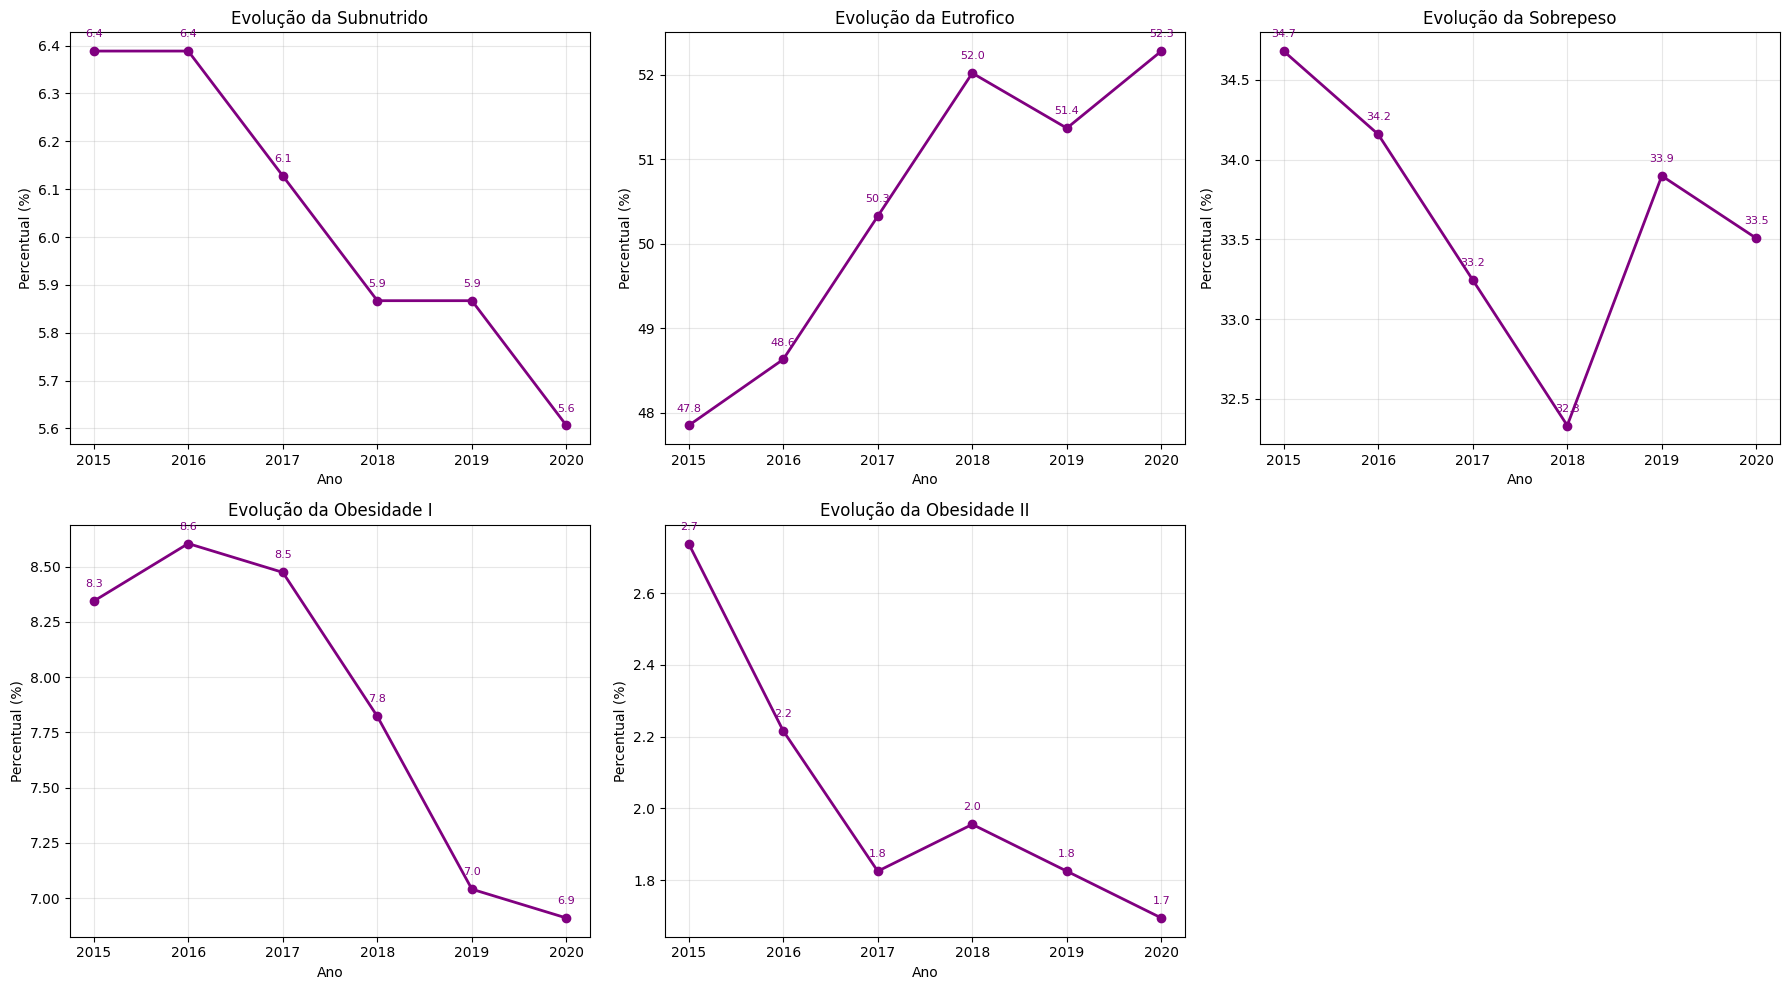

In [ ]:
# Bibliotecas Necessarias
import matplotlib.pyplot as plt
import pandas as pd

# Classificação conforme IMC

def classificar_imc(imc):
    if imc < 18.5: 
        return 'Subnutrido'
    elif 18.5 <= imc < 25: 
        return 'Eutrofico'
    elif 25 <= imc < 30: 
        return 'Sobrepeso'
    elif 30 <= imc < 35: 
        return 'Obesidade I'
    else: 
        return 'Obesidade II'

# Função para definir a evolução no grafico
def plotar_evolucao(df_final):
    categorias = ['Subnutrido', 'Eutrofico', 'Sobrepeso', 'Obesidade I', 'Obesidade II']
    
    # colunas do dataframe para serem coletados
    colunas_imc = [
        'IMC_2015_contrafactual', 'IMC_2016_contrafactual', 
        'IMC_2017_contrafactual', 'IMC_2018_contrafactual',
        'IMC_2019_contrafactual', 'IMC_2020_contrafactual'
    ]# anos  medidos
    anos = [2015, 2016, 2017, 2018, 2019, 2020]
     #grade de subplots (2 linhas x 3 colunas)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
   # Loop para cada categoria de  imc
    for idx, categoria in enumerate(categorias):
        if idx < len(axes):
            ax = axes[idx]
            percentuais = []
            for col in colunas_imc:
                classificacoes = df_final[col].apply(classificar_imc)
                percentual = (classificacoes == categoria).sum() / len(df_final) * 100
                percentuais.append(percentual)

            # Gráfico
            line = ax.plot(anos, percentuais, 'o-', linewidth=2, color='purple')[0]

            #  percentual
            for ano, percentual in zip(anos, percentuais):
                if percentual >= 0:
                    ax.annotate(f'{percentual:.1f}', 
                                (ano, percentual), 
                                textcoords="offset points", 
                                xytext=(0,10), 
                                ha='center', 
                                fontsize=8,
                                color=line.get_color())
            
            ax.set_title(f'Evolução da {categoria}')
            ax.set_xlabel('Ano')
            ax.set_ylabel('Percentual (%)')
            ax.grid(True, alpha=0.3)
            ax.set_xticks(anos)

    if len(categorias) < len(axes):
        for idx in range(len(categorias), len(axes)):
            fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# chamada 
plotar_evolucao(df_final)


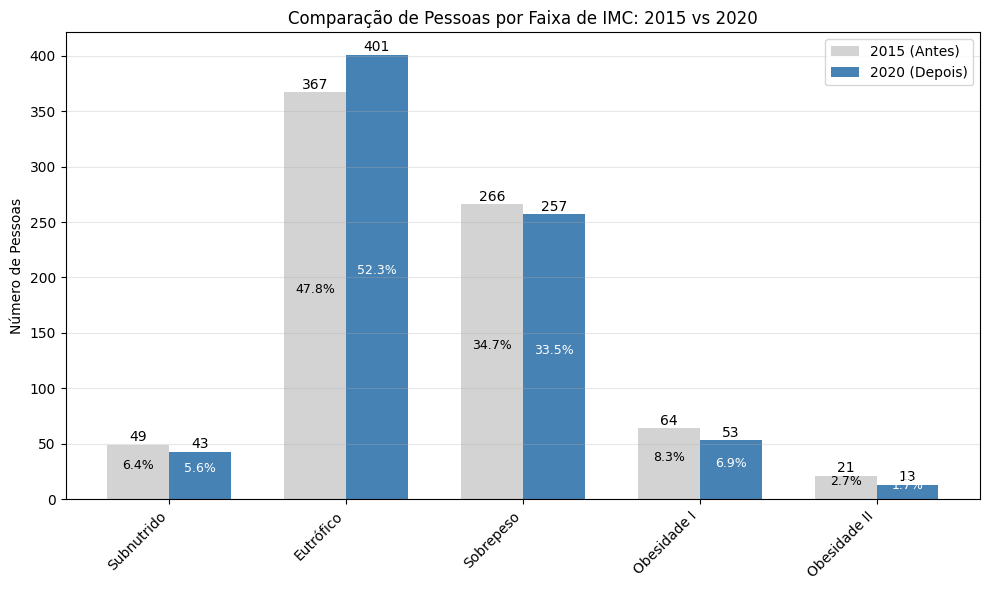

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def classificar_imc(imc):
    if imc < 18.5: 
        return "Subnutrido"
    elif imc < 25: 
        return "Eutrófico"
    elif imc < 30: 
        return "Sobrepeso"
    elif imc < 35: 
        return "Obesidade I"
    else: 
        return "Obesidade II"
# funcao para efetuar o compartivo
def analisar_imc_comparativo(df_final):
    #utilização da atulra
    altura = df_final['altura'].reset_index(drop=True)
    
    # IMC Antes e Depois dos contrafactuais
    imc_antes = df_final['Peso_2015_contrafactual'] / (altura**2)
    imc_depois = df_final['Peso_2020_contrafactual'] / (altura**2)
    
    faixas = ["Subnutrido","Eutrófico","Sobrepeso","Obesidade I","Obesidade II"]
    # criacao de uma dataframe compartivo
    df_comp = pd.DataFrame({
        'Antes': imc_antes.apply(classificar_imc).value_counts().reindex(faixas, fill_value=0),
        'Depois': imc_depois.apply(classificar_imc).value_counts().reindex(faixas, fill_value=0)
    })
    #calculo do total
    df_comp.loc['TOTAL'] = df_comp.sum()
    # calculo  associado ao porcentagem
    total_antes = df_comp['Antes'][:-1].sum()
    total_depois = df_comp['Depois'][:-1].sum()
    
    # Gráfico comparativo
    fig, ax = plt.subplots(figsize=(10,6))
    x = range(len(faixas))
    tamanho = 0.35
    
    barras_antes = ax.bar([i - tamanho/2 for i in x], df_comp['Antes'][:-1], tamanho, label='2015 (Antes)', color='lightgray')
    barras_depois = ax.bar([i + tamanho/2 for i in x], df_comp['Depois'][:-1], tamanho, label='2020 (Depois)', color='steelblue')
    
    # Números absolutos em cima e porcentagem no centro
    for barra, valor, total in zip(barras_antes, df_comp['Antes'][:-1], [total_antes]*len(faixas)):
        ax.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.5, f'{int(valor)}',
                ha='center', va='bottom', fontsize=10)
        ax.text(barra.get_x() + barra.get_width()/2, barra.get_height()/2, f'{valor/total*100:.1f}%',
                ha='center', va='bottom', fontsize=9, color='black')
    
    for barra, valor, total in zip(barras_depois, df_comp['Depois'][:-1], [total_depois]*len(faixas)):
        ax.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.5, f'{int(valor)}',
                ha='center', va='bottom', fontsize=10)
        ax.text(barra.get_x() + barra.get_width()/2, barra.get_height()/2, f'{valor/total*100:.1f}%',
                ha='center', va='bottom', fontsize=9, color='white')
    
    ax.set_xticks(x)
    ax.set_xticklabels(faixas, rotation=45, ha='right')
    ax.set_ylabel('Número de Pessoas')
    ax.set_title('Comparação de Pessoas por Faixa de IMC: 2015 vs 2020')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return imc_depois, df_comp

#chamada
imc_final, df_comparativo = analisar_imc_comparativo(df_final)


# Visualização

In [58]:
df =df_final

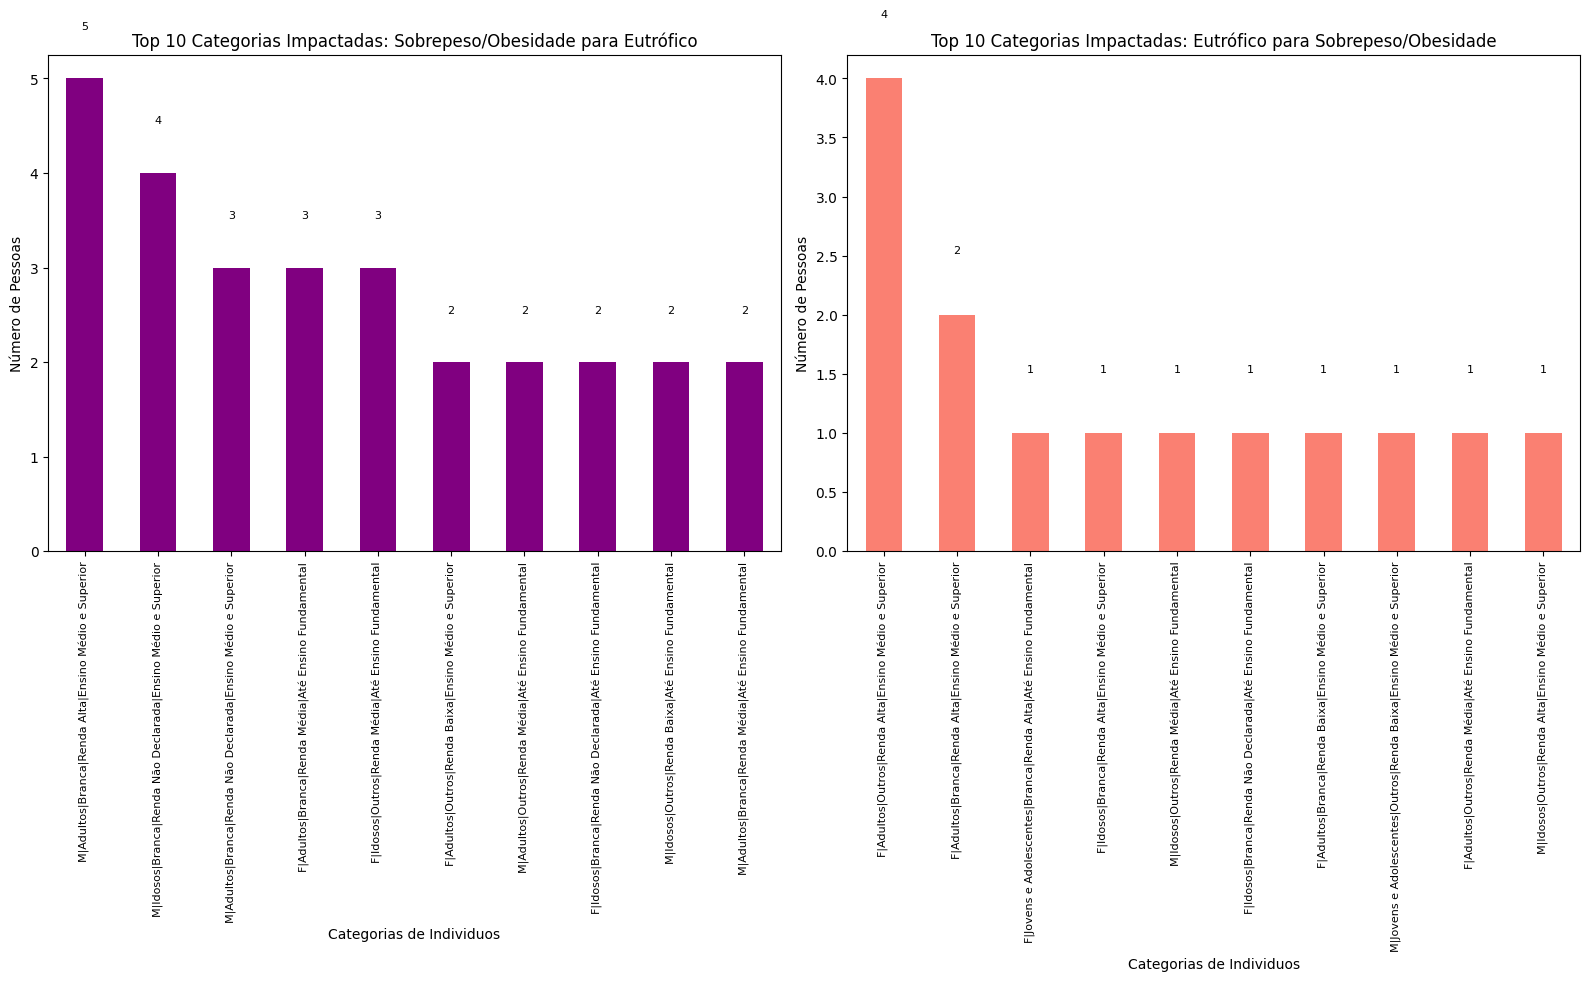

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

 # classificação  do IMC
def classificar_imc(imc):
    if imc < 18.5:
        return 'Subnutrido'
    elif imc < 25:
        return 'Eutrófico'
    elif imc < 30:
        return 'Sobrepeso'
    elif imc < 35:
        return 'Obesidade I'
    else:
        return 'Obesidade II'


 # Utilização do IMC PARA Comparar

df_final['Cat_2015'] = df_final['IMC_2015_contrafactual'].apply(classificar_imc)
df_final['Cat_2020'] = df_final['IMC_2020_contrafactual'].apply(classificar_imc)

# Evolução do Modelo
melhorou = df_final[df_final['Cat_2015'].isin(['Sobrepeso','Obesidade I','Obesidade II']) & 
                    (df_final['Cat_2020'] == 'Eutrófico')]
piorou  = df_final[(df_final['Cat_2015'] == 'Eutrófico') & 
                   df_final['Cat_2020'].isin(['Sobrepeso','Obesidade I','Obesidade II'])]

top_melhorou = melhorou['Categorias'].value_counts().head(10)
top_piorou   = piorou['Categorias'].value_counts().head(10)

# Grafico , com tratamento de erro, em caso, dele nao achar dados, informar mensagem vazia
def plot_top(ax, data, titulo, cor, mensagem_vazio):
    if not data.empty:
        data.plot(kind='bar', color=cor, ax=ax)
        ax.set_title(titulo)
        ax.set_ylabel('Número de Pessoas')
        ax.set_xlabel('Categorias de Individuos')
        ax.set_xticklabels(data.index, rotation=90, fontsize=8)
        for i, v in enumerate(data):
            ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)
    else:
        ax.text(0.5, 0.5, mensagem_vazio, ha='center', va='center', fontsize=12)
        ax.set_axis_off()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
plot_top(axes[0], top_melhorou, 'Top 10 Categorias Impactadas: Sobrepeso/Obesidade para Eutrófico', 'purple', 'Nenhum informacao')
plot_top(axes[1], top_piorou, 'Top 10 Categorias Impactadas: Eutrófico para Sobrepeso/Obesidade', 'salmon', 'Nenhum indivíduo passou de Eutrófico para Sobrepeso/Obesidade')

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


C:\Users\vimed\AppData\Local\Temp\ipykernel_44388\771545615.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_classe.index, rotation=45, ha='right')
C:\Users\vimed\AppData\Local\Temp\ipykernel_44388\771545615.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


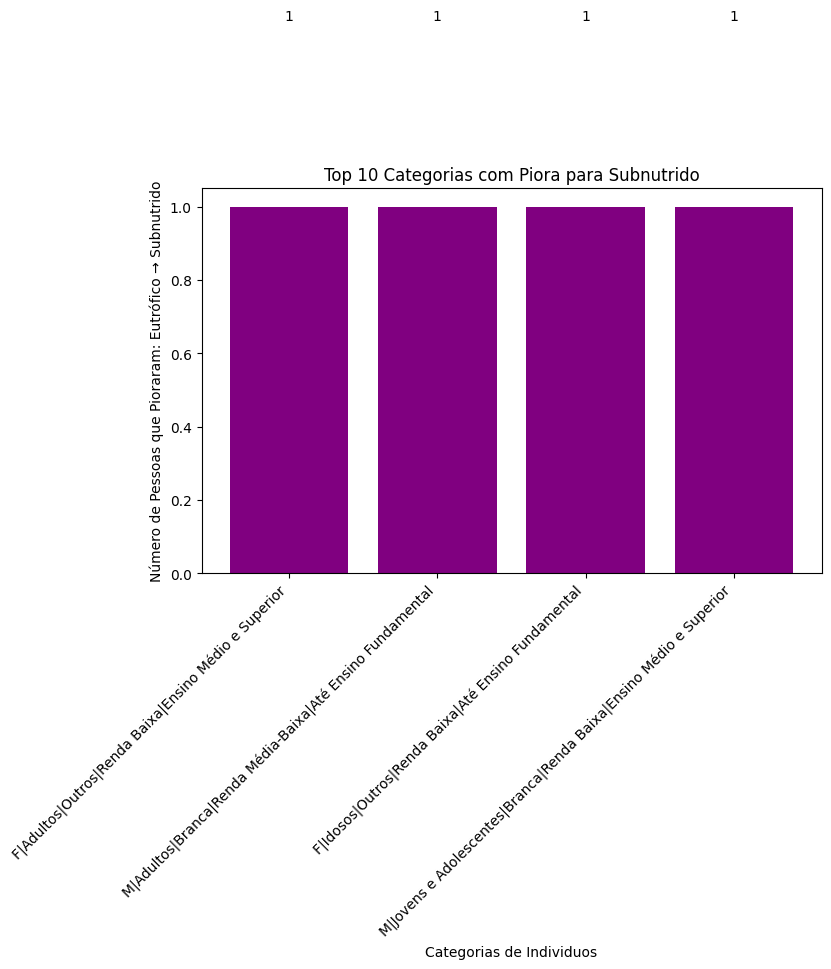

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Classificação de IMC
def classificar_imc(imc):
    if imc < 18.5:
        return 'Subnutrido'
    elif imc < 25:
        return 'Eutrófico'
    elif imc < 30:
        return 'Sobrepeso'
    elif imc < 35:
        return 'Obesidade I'
    else:
        return 'Obesidade II'

 # Utilização do IMC PARA Comparar
df_final['Cat_2015'] = df_final['IMC_2015_contrafactual'].apply(classificar_imc)
df_final['Cat_2020'] = df_final['IMC_2020_contrafactual'].apply(classificar_imc)

## Colocar quais individuos pioraram
piorou_subnutrido = df_final[
    (df_final['Cat_2015'] == 'Eutrófico') & (df_final['Cat_2020'] == 'Subnutrido')
]

top_classe = piorou_subnutrido['Categorias'].value_counts().head(10)

# grafico
if not top_classe.empty:
    fig, ax = plt.subplots(figsize=(8,5))
    bars = ax.bar(top_classe.index, top_classe.values, color='purple')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height),
                ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('Número de Pessoas que Pioraram: Eutrófico → Subnutrido')
    ax.set_xlabel('Categorias de Individuos')
    ax.set_title('Top 10 Categorias com Piora para Subnutrido')
    ax.set_xticklabels(top_classe.index, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Visualização nos Mapas via Distribuição nos Bairros

In [ ]:
!pip install geopandas matplotlib contextily folium  selenium pillow webdriver-manager overpypip  googlemaps



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vimed\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import warnings

warnings.simplefilter("ignore", UnicodeWarning)
# carregamento novamene do banco de dados
df = pd.read_stata(r"C:\Users\vimed\Downloads\Banco_ISA_AF_Ambiente_Vinicius (5).dta")
# filtragem dos dados  de geolocalizacao
df = df.filter([
    'id_original', 'N_domicilio',
    'lat2015', 'long2015', 'lat2020', 'long2020'
])
#consolidação do novodataframe
df_final = df_final.merge(df,right_on='id_original',left_on='id', how='inner')

In [63]:
df_final=df_final.loc[:, ~df_final.columns.str.endswith(('_x', '_y'))]


In [65]:
pip install googlemaps


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vimed\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [66]:
df_final  = df_final.loc[:, ~df_final.columns.str.endswith(('_x', '_y'))]


C:\Users\vimed\AppData\Local\Temp\ipykernel_25160\3834450577.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


C:\Users\vimed\AppData\Local\Temp\ipykernel_25160\3834450577.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_25160\3834450577.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_25160\3834450577.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


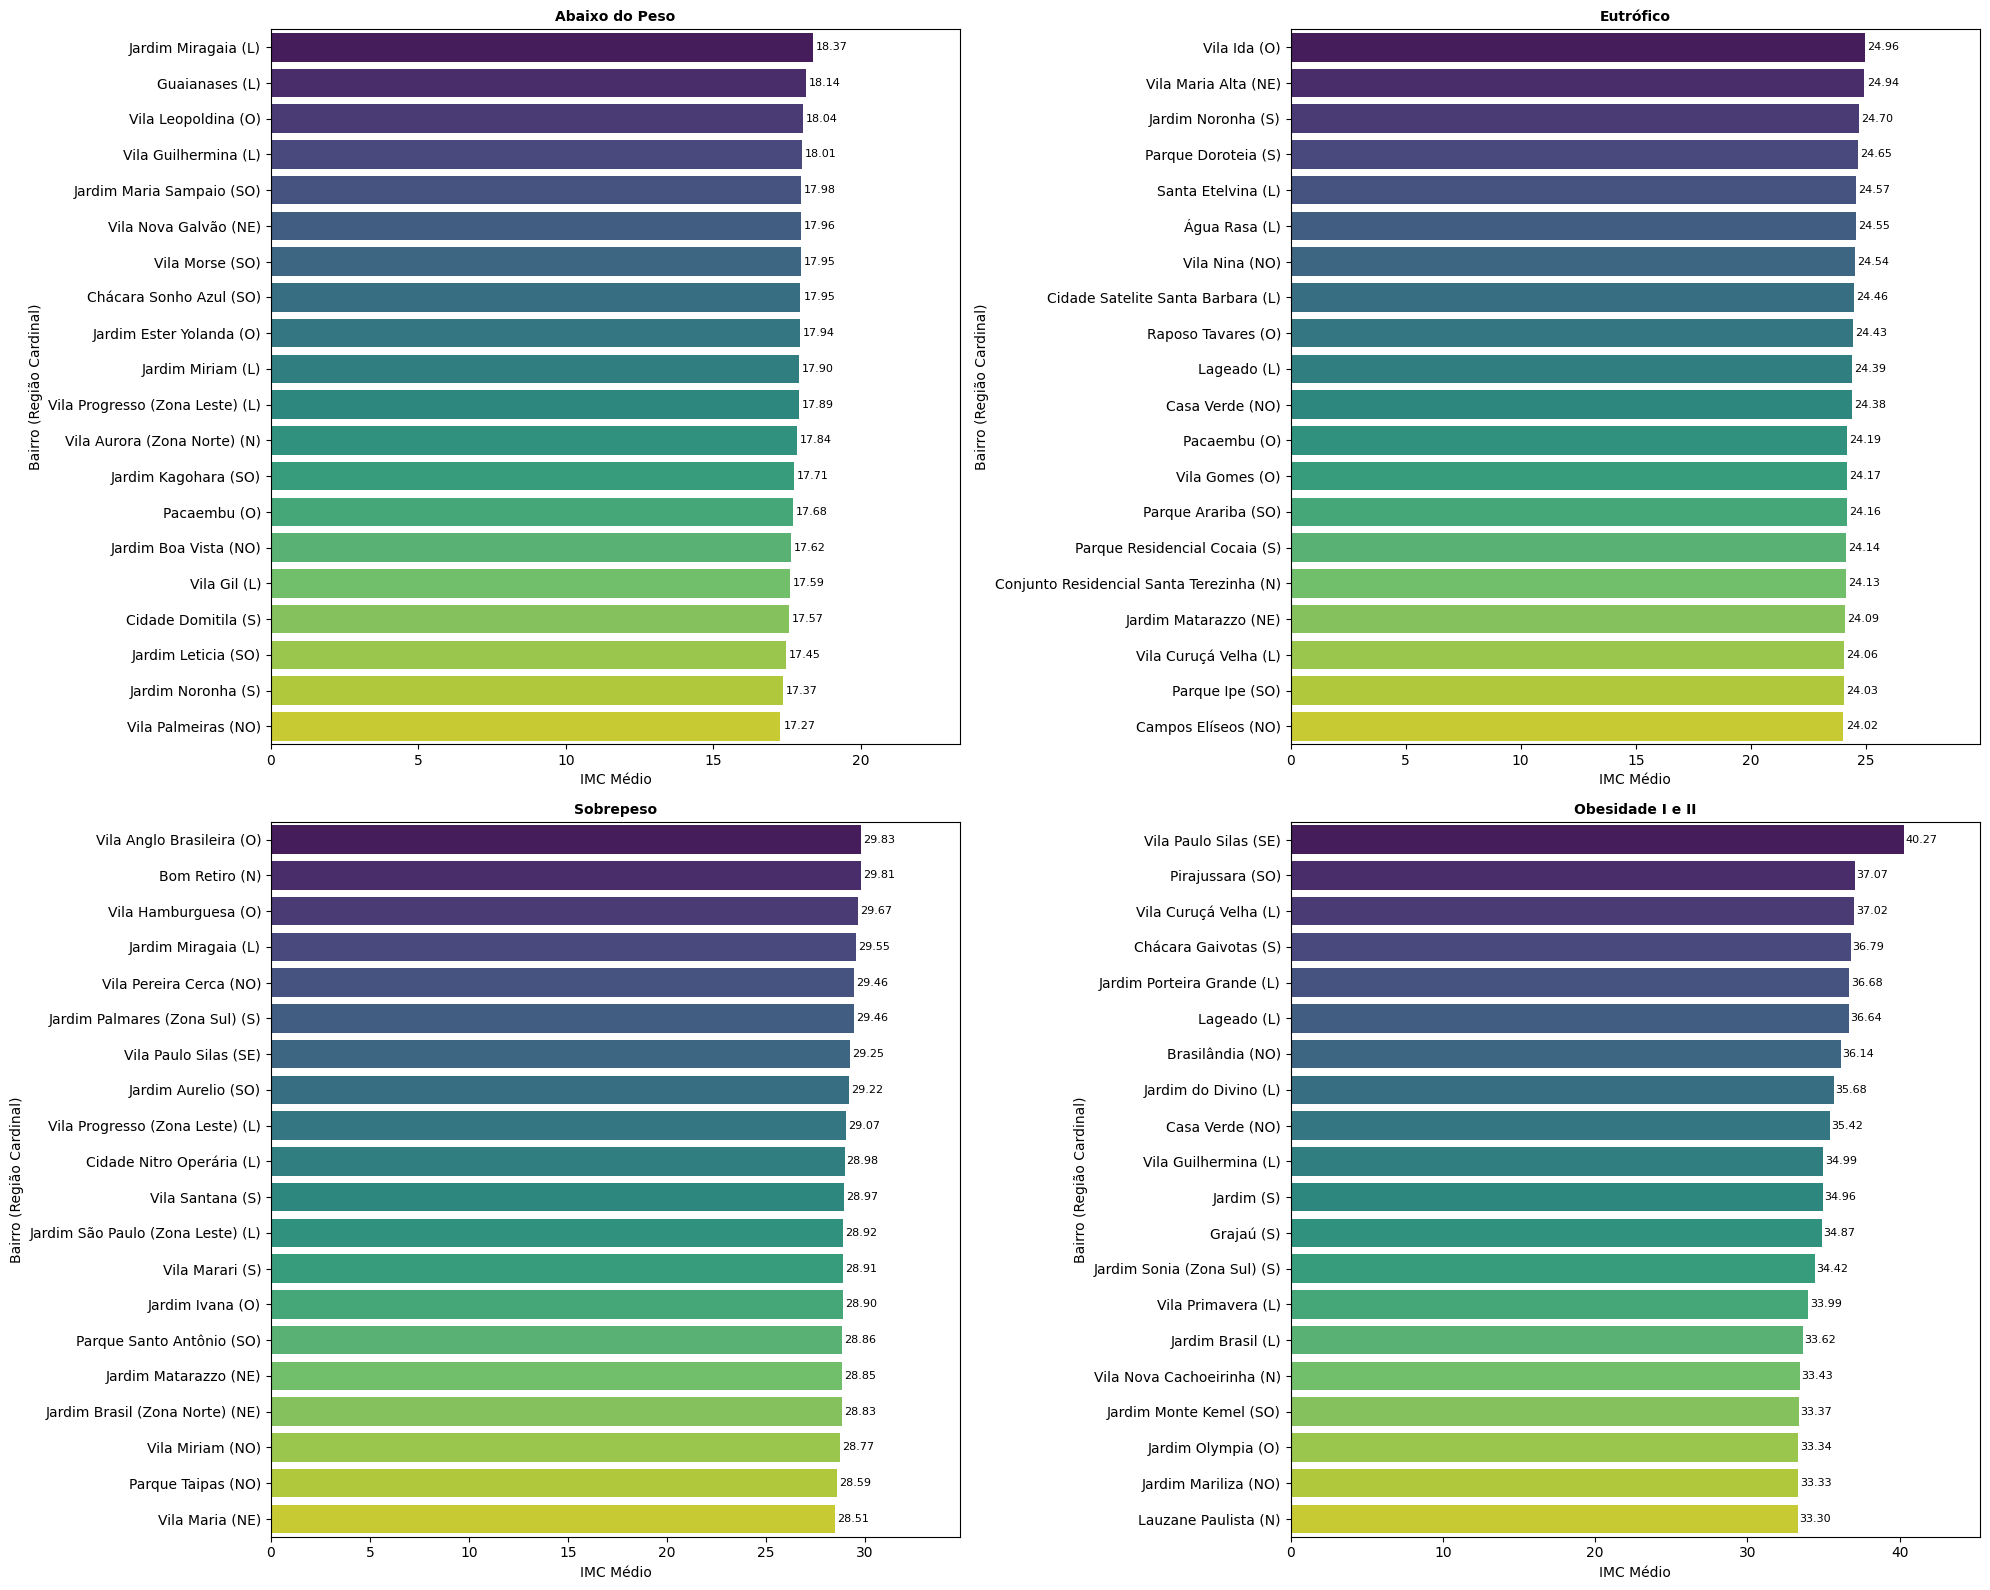

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Função para plotar  os topo 20 bairros de maneira descrecente com imc medios
def plot_top20_ax(ax, df_agg, categoria_nome):
    top20 = df_agg.sort_values(by='imc_medio', ascending=False).head(20).reset_index(drop=True)
    # criação de rotulo ordenado
    top20['bairro_regiao'] = top20['bairro'] + ' (' + top20['regiao_cardinal'] + ')'
# criação dos graficos de barra
    sns.barplot(
        data=top20,
        y='bairro_regiao',
        x='imc_medio',
        palette="viridis",
        dodge=False,
        ax=ax
    )
    #adicioanr os valores ao lado das barras
    for i, v in enumerate(top20['imc_medio']):
        ax.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=8)
    
    ax.set_title(categoria_nome, fontsize=10, fontweight='bold')
    ax.set_xlabel('IMC Médio')
    ax.set_ylabel('Bairro (Região Cardinal)')
    max_val = top20['imc_medio'].max()
    ax.set_xlim(0, max_val + 5)

# figura 2*2
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
axs = axs.flatten()

# Listar categorias e respectivos dataframe agregados

for ax, (nome, df_cat) in zip(axs, categorias):
    plot_top20_ax(ax, df_cat, nome)
#execucao da plotagem
plt.tight_layout()
plt.show()


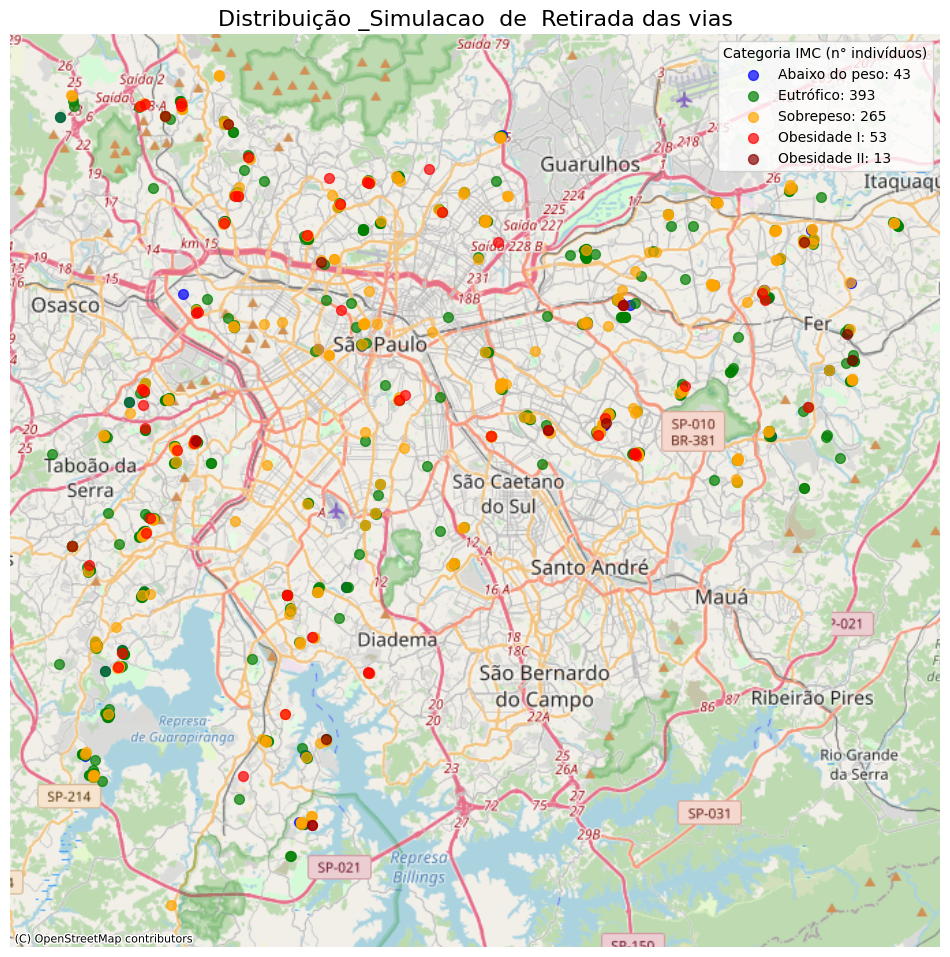

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
# preparação do datagrame
df_heat = df_final.dropna(subset=["lat2020", "long2020", "IMC_2020_contrafactual"]).copy()



#classificação do IMC
def classificar_imc(imc):
    if imc < 18.5: return "Abaixo do peso"
    elif 18.5 <= imc < 25: return "Eutrófico"
    elif 25 <= imc < 30: return "Sobrepeso"
    elif 30 <= imc < 35: return "Obesidade I"
    else: return "Obesidade II"

#Aplicação da Funcao das categoriazacao com o imc de 2020 contrafactual
df_heat["categoria_imc"] = df_heat["IMC_2020_contrafactual"].apply(classificar_imc)

#conversão do dataframe para geodataframe
gdf = gpd.GeoDataFrame(
    df_heat,
    geometry=[Point(xy) for xy in zip(df_heat["long2020"], df_heat["lat2020"])],
    crs="EPSG:4326"
)
# conversao das geocoordenadas
gdf = gdf.to_crs(epsg=3857)

# paleta de cores por categorias
cores = {
    "Abaixo do peso": "blue",
    "Eutrófico": "green",
    "Sobrepeso": "orange",
    "Obesidade I": "red",
    "Obesidade II": "darkred"
}
# centralizacao do mapa
fig, ax = plt.subplots(figsize=(12,12))


legendas = []
#percorrer cada categoria
for categoria, cor in cores.items():
    subset = gdf[gdf["categoria_imc"] == categoria]
    if not subset.empty:
        subset.plot(ax=ax, markersize=50, color=cor, alpha=0.7)
        legendas.append(f"{categoria}: {len(subset)}")

#inserir o mapa no fundo
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()


plt.legend(legendas, title="Categoria IMC (n° indivíduos)", loc="upper right", fontsize=10)
plt.title("Distribuição _Simulacao  de  Retirada das vias"  , fontsize=16)
# execucaoca 

plt.show()
